In [1]:

################################################
##
## image classification
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import os
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report


In [2]:

## !pip install mlxtend


In [3]:

#######################################################

from fastai.vision.all import *


#######################################################

N_EPOCHS = 10000          ## 4000
batch_size = 10   ## 5    ## 32
learning_rate =  0.1    ## 0.01   ## 1e-5 


#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################



## Load Data


In [4]:

## Download SkyScanCorpus with a folder inside for each class (e.g. boeing, airbus, etc). 
## Put images in each corresponding folder

path = Path('/home/rcalix/Desktop/trainCIFAR10')


In [5]:

fns = get_image_files(path)
fns


(#50000) [Path('/home/rcalix/Desktop/trainCIFAR10/dog/3879.jpg'),Path('/home/rcalix/Desktop/trainCIFAR10/dog/4872.jpg'),Path('/home/rcalix/Desktop/trainCIFAR10/dog/4400.jpg'),Path('/home/rcalix/Desktop/trainCIFAR10/dog/1098.jpg'),Path('/home/rcalix/Desktop/trainCIFAR10/dog/4061.jpg'),Path('/home/rcalix/Desktop/trainCIFAR10/dog/4717.jpg'),Path('/home/rcalix/Desktop/trainCIFAR10/dog/1049.jpg'),Path('/home/rcalix/Desktop/trainCIFAR10/dog/0609.jpg'),Path('/home/rcalix/Desktop/trainCIFAR10/dog/0268.jpg'),Path('/home/rcalix/Desktop/trainCIFAR10/dog/1428.jpg')...]


## DataLoader


In [6]:

## This is a data loader

## parent_label -> simply gets the name of the folder a file is in

fruits = DataBlock(
     blocks = (ImageBlock, CategoryBlock),
     get_items = get_image_files,
     splitter = RandomSplitter(valid_pct=0.2, seed=42),
     get_y = parent_label,
     item_tfms = Resize(128)  ## by default it crops
)


In [7]:

dls = fruits.dataloaders(path)



## View some of the data


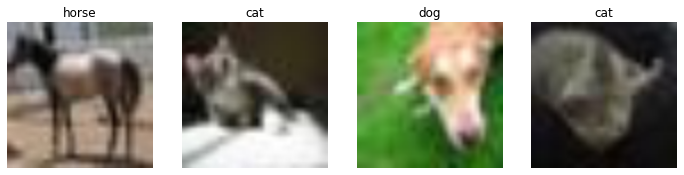

In [8]:

## by defaullt it will give the model batches of 64 for training and testing

## to view

dls.valid.show_batch(max_n=4, nrows=1)



## Example of padding the images


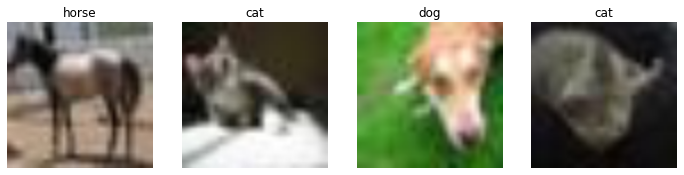

In [9]:

## instead of cropping

## we can pad the images

fruits = fruits.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))

dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)



## Squishing the images


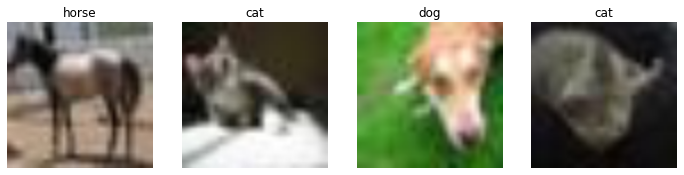

In [10]:

## or we can squish them

fruits = fruits.new(item_tfms=Resize(128, ResizeMethod.Squish))

dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)



## Random cropping of an image is considered better


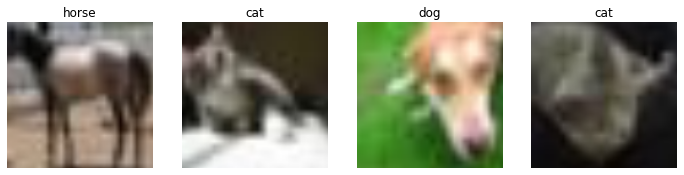

In [11]:

## random cropping of an image is considered better

fruits = fruits.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))

dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)


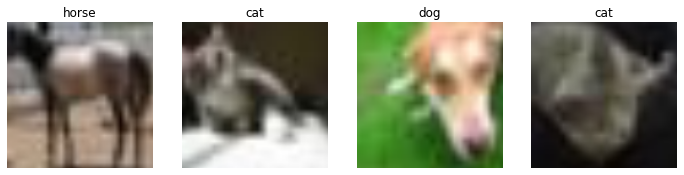

In [12]:

fruits = fruits.new(item_tfms=RandomResizedCrop(128, min_scale=0.5))

dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)


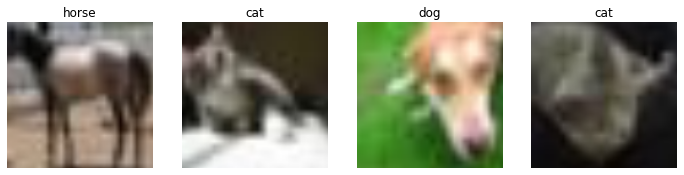

In [13]:

fruits = fruits.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))

dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)



## Other data augmentation


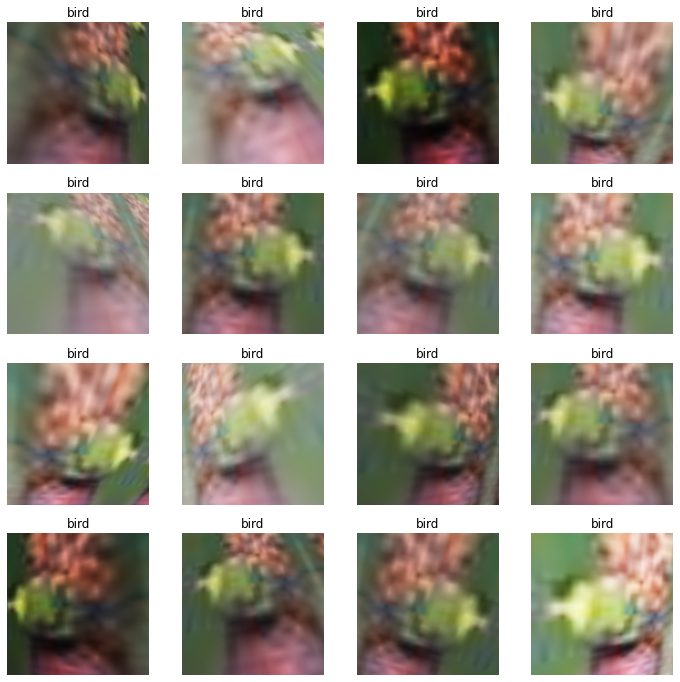

In [14]:

## data augmentation: rotation, flipping, perspective warping, contrast and brightness changes
## via GPU intensive batch_transforms

fruits = fruits.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = fruits.dataloaders(path)
dls.train.show_batch(max_n=16, nrows=4, unique=True)




## Fine Tune the pre-trained image classifier

* Here we use a CNN learner based on ResNet18

* CNN = Convolutional Neural Network


In [15]:

## now fine tune cnn_learner with our data

fruits = fruits.new(
     item_tfms=RandomResizedCrop(224, min_scale=0.5),
     batch_tfms=aug_transforms()
)

dls = fruits.dataloaders(  path  )

learn = cnn_learner(dls, resnet18, metrics=error_rate)    ## metrics=batch_accuracy, metrics=accuracy

learn.fine_tune(4)


/home/rcalix/.local/lib/python3.8/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/rcalix/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rcalix/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.397649,1.013622,0.358300,00:52


epoch,train_loss,valid_loss,error_rate,time
0,0.820248,0.565534,0.198900,01:05
1,0.607582,0.444719,0.154100,01:01
2,0.497181,0.364041,0.127000,01:01
3,0.417070,0.350533,0.124400,01:01



## Confusion Matrix


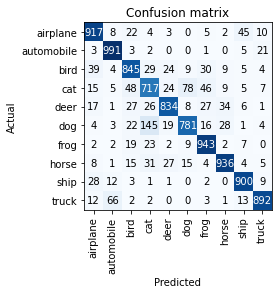

In [16]:

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()


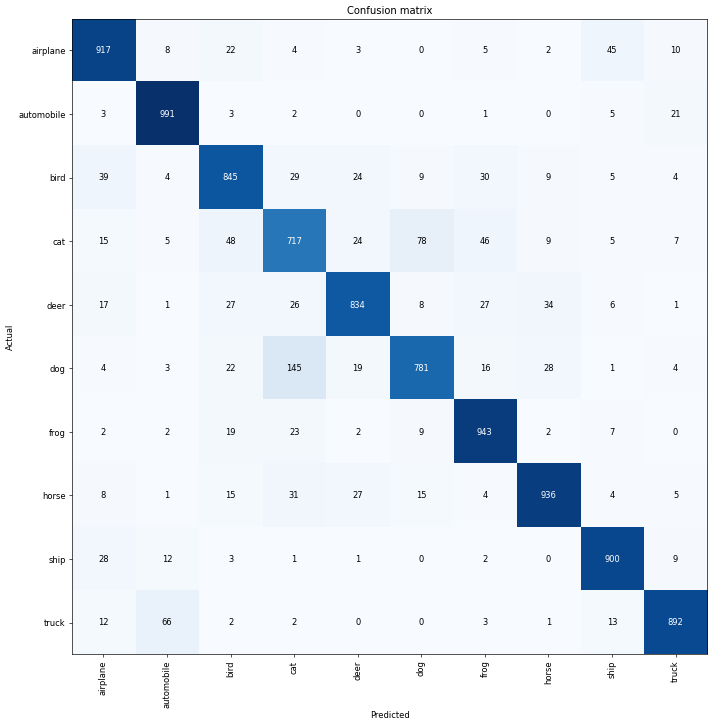

In [17]:

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)



## ML Performance Metrics


In [18]:

preds, y, losses = learn.get_preds(with_loss=True)


In [19]:

preds.shape


y_pred = torch.argmax(preds, dim=1)
y_pred.shape


torch.Size([10000])

In [20]:

y.shape


torch.Size([10000])

In [21]:

y_np       = y.numpy()
y_pred_np = y_pred.numpy()

accuracy = accuracy_score(y_np, y_pred_np)

f1 = f1_score(y_np, y_pred_np, average='weighted')

print(accuracy)
print(f1)


0.8756
0.8751012324248036


In [22]:

learn.dls.vocab


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [23]:

print(classification_report(y_np, y_pred_np))


              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1016
           1       0.91      0.97      0.94      1026
           2       0.84      0.85      0.84       998
           3       0.73      0.75      0.74       954
           4       0.89      0.85      0.87       981
           5       0.87      0.76      0.81      1023
           6       0.88      0.93      0.90      1009
           7       0.92      0.89      0.91      1046
           8       0.91      0.94      0.92       956
           9       0.94      0.90      0.92       991

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.88     10000



In [24]:

print(classification_report(y_np, y_pred_np, target_names=learn.dls.vocab))


              precision    recall  f1-score   support

    airplane       0.88      0.90      0.89      1016
  automobile       0.91      0.97      0.94      1026
        bird       0.84      0.85      0.84       998
         cat       0.73      0.75      0.74       954
        deer       0.89      0.85      0.87       981
         dog       0.87      0.76      0.81      1023
        frog       0.88      0.93      0.90      1009
       horse       0.92      0.89      0.91      1046
        ship       0.91      0.94      0.92       956
       truck       0.94      0.90      0.92       991

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.88     10000




## Plot some losses


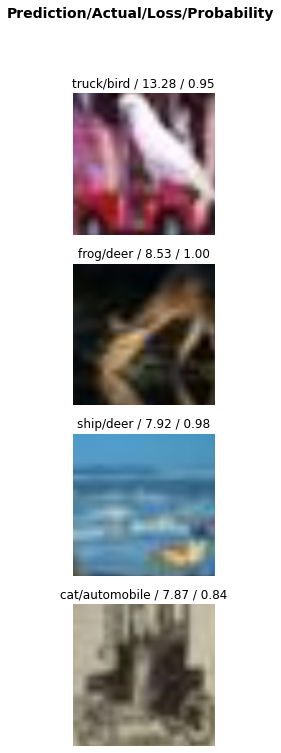

In [26]:

## plot_top_losses shows us the images with the highest loss in our dataset


interp.plot_top_losses(4, nrows=4)


In [27]:

## will save an export file called export.pkl to save the model


learn.export("CIFAR10ModelLabels.pkl")


In [28]:

## load_model from file


learn_inf = load_learner('CIFAR10ModelLabels.pkl')


In [29]:

img = '/home/rcalix/Desktop/trainCIFAR10/dog/1428.jpg'


is_plane, _, probs = learn.predict(img)
print(is_plane)
print(probs)



dog
TensorBase([    0.0000,     0.0000,     0.0001,     0.0038,     0.0001,
                0.9954,     0.0005,     0.0001,     0.0000,     0.0000])


In [30]:

is_plane, _, probs = learn_inf.predict(img)
print(is_plane)
print(probs)


dog
TensorBase([    0.0000,     0.0000,     0.0001,     0.0038,     0.0001,
                0.9954,     0.0005,     0.0001,     0.0000,     0.0000])


In [31]:

learn_inf.dls.vocab


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

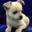

In [33]:

im = Image.open(img)
im.thumbnail((256,256))
im


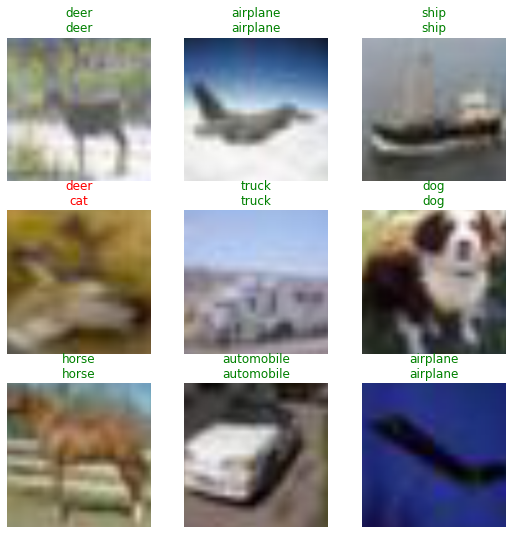

In [34]:

learn.show_results()


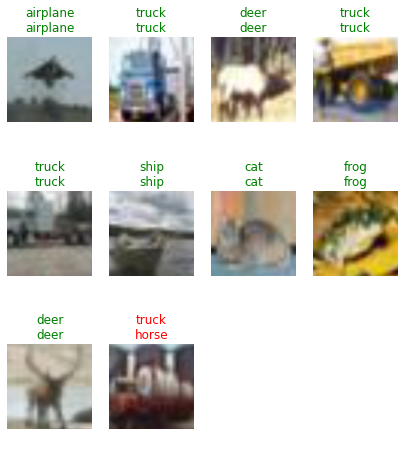

In [35]:

learn.show_results(max_n=10, figsize=(7, 8))
